# ART - Adversarial Patch - TensorFlow v2

ImageNet-patch patches used as training for adversarial patch.

In [20]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch

import os
import glob
import gzip
import pickle

def bgr_to_rgb(x):
    return x[:, :, ::-1]

# Settings

In [74]:
target_name = 'goldfish'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes  =1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

# Model definition

In [75]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=nb_classes,
                             input_shape=image_shape, clip_values=clip_values, 
                             preprocessing=([mean_b, mean_g, mean_r], np.array([1.0, 1.0, 1.0])))

# ImageNet-Patch Patches

In [80]:
# Load the patches
with gzip.open(os.path.join(os.getcwd(), "assets/imagenet_patch.gz"), 'rb') as f:
    imagenet_patch = pickle.load(f)
patches, targets, info = imagenet_patch
images = patches
images = images.numpy().transpose(0,2,3,1)
images = images[:, :, ::-1].astype(np.float32) # RGB to BGR
images = images*255

In [17]:
'''images_list = list()
for image_path in images:
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)'''

In [18]:
'''def bgr_to_rgb(x):
    return x[:, :, ::-1]'''

In [ ]:
'''for i in range(images.shape[0]):
    plt.imshow(images[i])
    plt.show(block=False)'''

# Adversarial patch generation

In [86]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

label = 1 # target_to_classname[1] # name_to_label(target_name) 
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

Adversarial Patch TensorFlow v2:   0%|          | 0/500 [00:00<?, ?it/s]

# Adversarial Patch

images bgr normalized 0-255, clipping 0-255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


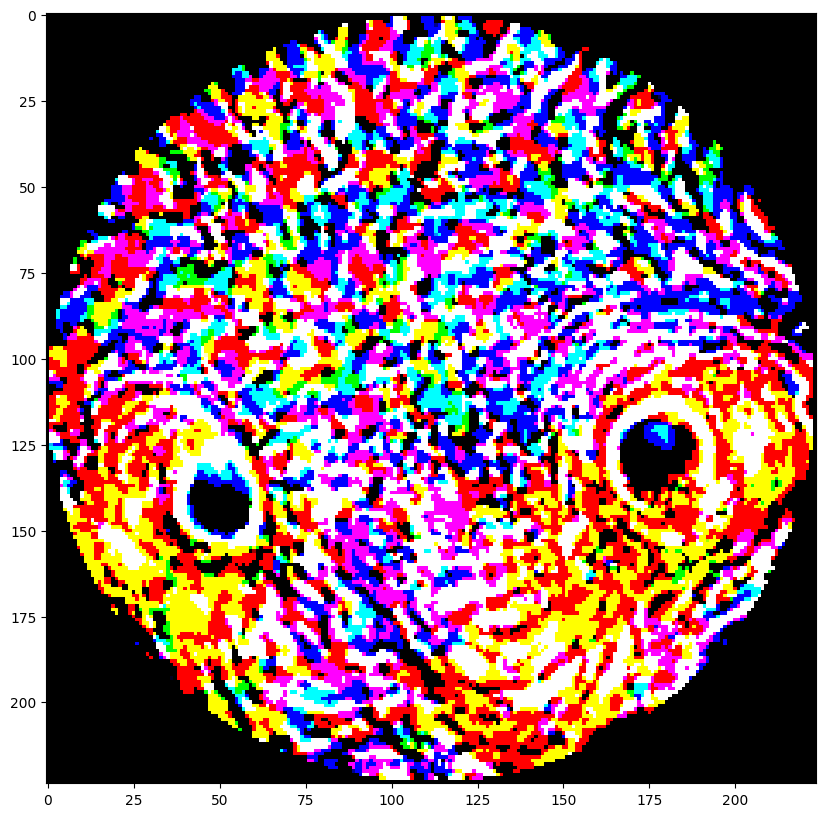

In [87]:
plt.imshow((bgr_to_rgb(patch) * patch_mask))

Patch from patches - clipping 0-1. Patches bgr normalized 0-1.

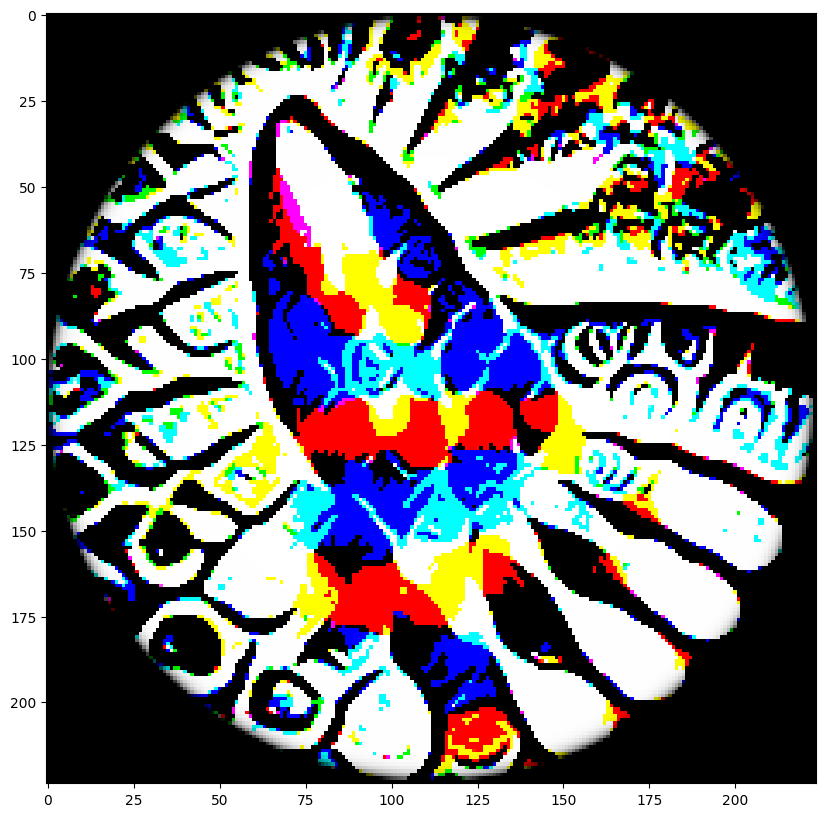

In [64]:
plt.imshow((bgr_to_rgb(patch) * patch_mask))

# Evaluation

In [67]:
def predict_model_imagenet_patch(classifier, image):
    plt.imshow(bgr_to_rgb(image))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

def predict_model(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

In [90]:
patched_images = ap.apply_patch(images, scale=0.5)

images bgr normalized 0-255, clipping 0-255

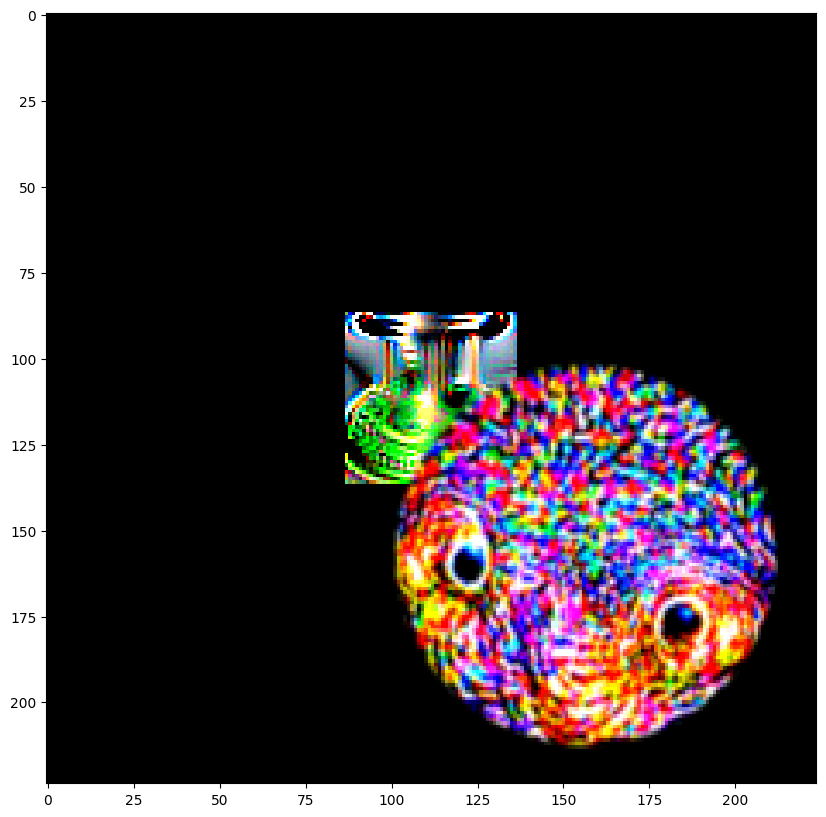

Predictions:
perfume  0.36
goldfish 0.21
goblet   0.11
beaker   0.10
loupe    0.07


In [91]:
predict_model(tfc, patched_images[0])

images bgr normalized 0-1, clipping 0-1

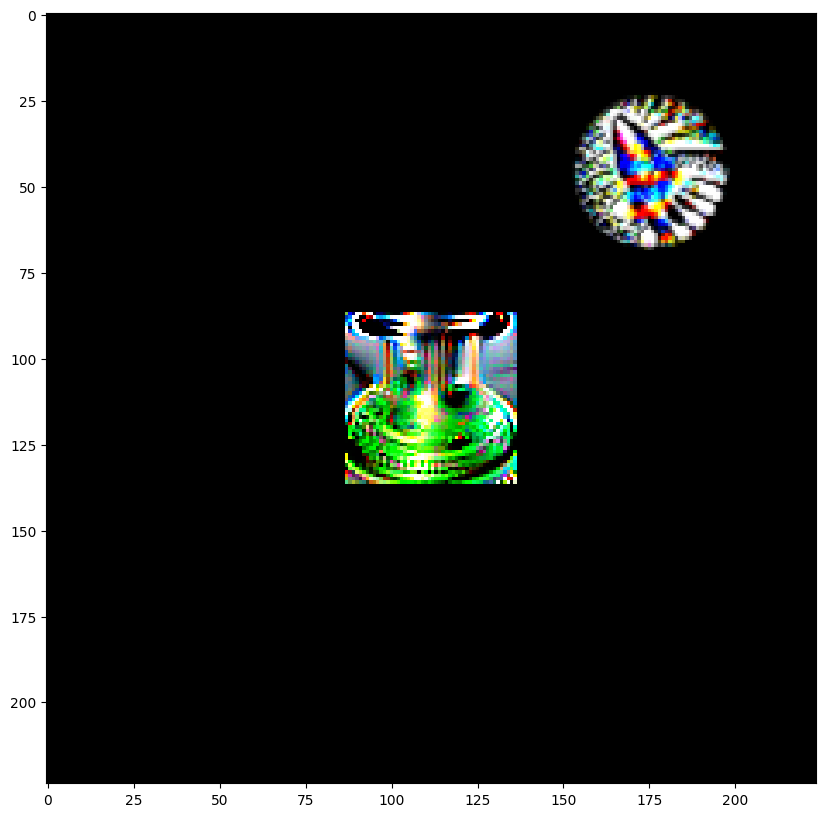

Predictions:
web_site      0.06
digital_clock 0.06
nematode      0.05
matchstick    0.05
television    0.03


In [70]:
predict_model_imagenet_patch(tfc, patched_images[0])